12.40625 12.166666666666666 12.720779220779221 11.988372093023257
13.432432432432432 10.348837209302326 11.421686746987952 12.311688311688311
15.333333333333334 11.927536231884059 11.83448275862069 11.745454545454546
13.55 10.722222222222221 11.14102564102564 11.648809523809524
13.028571428571428 12.510204081632653 11.610738255033556 11.946107784431138
11.40625 11.61111111111111 11.516129032258064 11.36723163841808


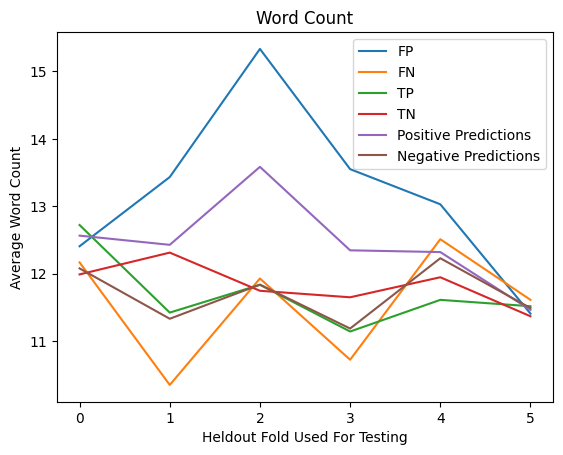

In [21]:
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer

from cross_validation import *

BOW_FILE = "bow_columns_list.txt"
REGRESSION_PKL_FILE = "regression_mdl.pkl"
WEBSITE_MAPPING = {'imdb': 0, 'amazon': 1, 'yelp': 2}
RANDOM_STATE = 132
NUM_FOLDS = 6

### IO
import pickle
REGRESSION_PKL_FILE = "regression_mdl.pkl"

def write_out_model(model, filename=REGRESSION_PKL_FILE):
    with open(REGRESSION_PKL_FILE, 'wb') as f:
        pickle.dump(model, f)
        print(f'model saved as: {REGRESSION_PKL_FILE}')

def read_in_model(filename=REGRESSION_PKL_FILE):
    with open(REGRESSION_PKL_FILE, 'rb') as f:
        model = pickle.load(f)
    return model

def copy_model_hyperparameters(model):
    return sklearn.linear_model.LogisticRegression(solver=model.solver, C=model.C, fit_intercept=model.fit_intercept, penalty=model.penalty, tol=model.tol)

### BOW
def make_bag_of_words_from_vocab(text_series, ngram_range=(1, 1), max_features=1000, vocabulary_file=BOW_FILE, binary=True):
    with open(vocabulary_file, 'r') as file:
        vocabulary = file.read().splitlines()
    text_series = [text_list[1] for text_list in text_series]
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features, stop_words='english', vocabulary=vocabulary, binary=binary)
    bow_matrix = vectorizer.fit_transform(text_series)
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return bow_df

def make_bag_of_words(text_series, ngram_range=(1, 1), max_features=1000, binary=True):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features, stop_words='english', binary=binary)
    bow_matrix = vectorizer.fit_transform(text_series)
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return bow_df

def make_bags_of_words(text_series, smallest, largest, max_features=None):
    df = pd.DataFrame(index=range(smallest, largest+1), columns=range(smallest, largest+1))
    for i in range(smallest, largest+1):
        for j in range(i, largest+1):
            df[i][j] = make_bag_of_words(text_series, ngram_range=(i, j), max_features=max_features)
    return df



### TRAINING
def find_best_hyperparameters(x_train_array, y_train_array, serialize=True):
    # penalties = ['l1', 'l2', 'elasticnet']
    penalties = ['l2']
    # C_grid = np.logspace(0, np.log10(2), 10)
    C_grid = [1.0284017999892119]
    # solvers = ['lbfgs', 'liblinear']
    solvers = ['liblinear']
    # fit_intercepts = [True, False]
    fit_intercepts = [True]
    # tols = np.logspace(-2, 0, 10)
    tols = [0.4146299840754365]

    total_iterations = len(tols) * len(fit_intercepts) * len(solvers) * len(C_grid) * len(penalties)
    print(f'total iterations: {total_iterations}')
    models_and_hyperparameters = []
    curr_itr = 0
    for penalty in penalties:
        for C in C_grid:
            for solver in solvers:
                for fit_intercept in fit_intercepts:
                    for tol in tols:
                        curr_itr += 1
                        model = sklearn.linear_model.LogisticRegression(penalty=penalty, C=C, solver=solver, fit_intercept=fit_intercept, tol=tol, max_iter=1000)
                        model.fit(x_train_array, y_train_array.ravel())
                        avg_test_error, rocauc, avg_train_error = get_error_and_rocauc(model, x_train_array, y_train_array)
                        models_and_hyperparameters.append((model, penalty, C, solver, fit_intercept, tol, avg_test_error, rocauc))
                        print(f'{curr_itr}/{total_iterations}', penalty, C, solver, fit_intercept, tol, avg_test_error, rocauc)

    min_err = 1000000
    best_model_tuple = ()
    for models_and_hyperparameter in models_and_hyperparameters:
        curr_err = models_and_hyperparameter[6]
        if curr_err < min_err:
            min_err = curr_err
            best_model_tuple = models_and_hyperparameter
    
    if serialize:
        best_model = best_model_tuple[0]
        print(best_model_tuple)
        write_out_model(best_model)
    return best_model_tuple



### TESTING
def get_error_and_rocauc(model, x_train_array, y_train_array, num_folds=NUM_FOLDS, random_state=RANDOM_STATE):
    train_err_per_fold, test_error_per_fold = train_models_and_calc_scores_for_n_fold_cv(model, x_train_array, y_train_array.ravel(), n_folds=num_folds, random_state=random_state)
    avg_test_error = np.average(test_error_per_fold)
    avg_train_error = np.average(train_err_per_fold)
    y_train_proba = model.predict_proba(x_train_array)[:,1]
    rocauc = sklearn.metrics.roc_auc_score(y_train_array, y_train_proba)
    return avg_test_error, rocauc, avg_train_error


def copy_and_test_model(model, x_train_array, y_train_array, num_folds=NUM_FOLDS, random_state=RANDOM_STATE):
    model = copy_model_hyperparameters(model)
    print(model, get_error_and_rocauc(model, x_train_array, y_train_array))




############ MAIN #############
def main(data_dir='./data_reviews'):
    x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
    y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))
    text = x_train_df['text']
    
    # choose bow
    bow_max_features = 1000
    bow = make_bag_of_words(x_train_df['text'], max_features=bow_max_features)
    # export as list
    with open(BOW_FILE, 'w') as file:
        for column in bow.columns:
            file.write(column + '\n')

    # make final training data
    x_train_df = pd.concat([x_train_df, bow], axis=1).drop(columns=['text', 'website_name'], axis=1)
    # x_train_df['website_name'].replace(website_mapping, inplace=True)
    x_train_array = x_train_df.to_numpy()
    y_train_array = y_train_df.to_numpy()
    
    # # find best hyperparameters
    # best_model_and_hyperparameters = find_best_hyperparameters(x_train_array=x_train_array, y_train_array=y_train_array, serialize=True)

    # # test with more words
    # x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
    # bow_max_features = 1000
    # bow = make_bag_of_words(x_train_df['text'], max_features=bow_max_features)
    # x_train_df = pd.concat([x_train_df, bow], axis=1).drop(columns=['text', 'website_name'], axis=1)
    # x_train_array = x_train_df.to_numpy()
    # y_train_array = y_train_df.to_numpy()
    # copy_and_test_model(best_model_and_hyperparameters[0], x_train_array, y_train_array)
    # write_out_model(best_model_and_hyperparameters[0])

    # use prior model
    # copy_and_test_model(read_in_model(), x_train_array, y_train_array)

    # current best model
    model = sklearn.linear_model.LogisticRegression(C=1.0284017999892119, solver='liblinear', tol=0.4146299840754365, fit_intercept=True, penalty='l2')
    # write_out_model(model)

    # 1D
    explore_word_count(model, x_train_array, y_train_array, text)


def explore_word_count(model, x_train_array, y_train_array, text):
    tp_word_count = []
    tn_word_count = []
    fp_word_count = []
    fn_word_count = []
    for fold_number in range(0, 6):
        train_ids_per_fold, test_ids_per_fold = make_train_and_test_row_ids_for_n_fold_cv(n_examples=x_train_array.shape[0], n_folds=NUM_FOLDS, random_state=RANDOM_STATE)
        model.fit(x_train_array[train_ids_per_fold[fold_number]], y_train_array[train_ids_per_fold[fold_number]].ravel())

        tp_indices = []
        tn_indices = []
        fp_indices = []
        fn_indices = []
        hits = 0
        misses = 0
        for index in test_ids_per_fold[fold_number]:
            prediction = model.predict([x_train_array[index]])
            if prediction == y_train_array[index]:
                if y_train_array[index] == 1:
                    tp_indices.append(index)
                else:
                    tn_indices.append(index)
                hits += 1
            else:
                if y_train_array[index] == 1:
                    fn_indices.append(index)
                else:
                    fp_indices.append(index)
                misses += 1
        
        fp_size_total = 0
        fn_size_total = 0
        tp_size_total = 0
        tn_size_total = 0
        for index in fp_indices:
            fp_size_total += len(text[index].split())
        for index in fn_indices:
            fn_size_total += len(text[index].split())
        for index in tp_indices:
            tp_size_total += len(text[index].split())
        for index in tn_indices:
            tn_size_total += len(text[index].split())
        # miss_word_count_tuples.append((fp_size_total / len(fp_indices), fn_size_total / len(fn_indices)))
        # hit_word_count_tuples.append((tp_size_total / len(tp_indices), tn_size_total / len(tn_indices)))
        fp_word_count.append(fp_size_total / len(fp_indices))
        fn_word_count.append(fn_size_total / len(fn_indices))
        tp_word_count.append(tp_size_total / len(tp_indices))
        tn_word_count.append(tn_size_total / len(tn_indices))
    for i in range(6):
        print(fp_word_count[i], fn_word_count[i], tp_word_count[i], tn_word_count[i])
    x_values = range(len(fp_word_count))

    # Plotting the values
    plt.plot(x_values, fp_word_count, label='FP')
    plt.plot(x_values, fn_word_count, label='FN')
    plt.plot(x_values, tp_word_count, label='TP')
    plt.plot(x_values, tn_word_count, label='TN')



    # Show plot
    
    
    negative_predictions = []
    positive_predictions = []
    for i in range(6):
        negative_predictions.append((fn_word_count[i] + tn_word_count[i]) / 2)
        positive_predictions.append((fp_word_count[i] + tp_word_count[i]) / 2)
    plt.plot(x_values, positive_predictions, label="Positive Predictions")
    plt.plot(x_values, negative_predictions, label="Negative Predictions")
    # Adding labels and title
    plt.xlabel('Heldout Fold Used For Testing')
    plt.ylabel('Average Word Count')
    plt.title('Word Count')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()